## Линейные и ансамблевые методы

### Обучение модели

Подключаемые модули

In [1]:
import pandas as pd
import numpy as np
import pickle
import math

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

Подгрузка данных о доменных именах с диска 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
with open('/content/gdrive/My Drive/Colab Notebooks/Res/input data/training_data.pkl', 'rb') as f:
        training_data = pickle.load(f)

Общая коллекция данных

In [5]:
all_data_dict = pd.concat([training_data['legit'], training_data['dga']], ignore_index=True)

Подсчет длин доменных имен (legit, dga)

In [6]:
all_data_dict['length'] = [len(x) for x in all_data_dict['domain']]

Отброс записей с длиной < 6

In [7]:
# Поскольку результаты классификации для таких доменов показывают близкие результаты 
# и в DGA-доменах нет записей с длиной < 6, в модели такие записи не будут учитываться
all_data_dict = all_data_dict[all_data_dict['length'] > 6]

Подсчет энтропии

In [8]:
def entropy(domain):
    prob = [float(domain.count(c)) / len(domain) for c in dict.fromkeys(list(domain))]
    ent = - sum([p * math.log(p) / math.log(2.0) for p in prob])
    return ent

In [9]:
all_data_dict['entropy'] = [entropy(x) for x in all_data_dict['domain']]

Создание модели для матрицы подсчета n-gram

In [10]:
# Минимальная частота = 0,001% для всех доменов
# Для 0,01% появляется много нулевых значений вхождений n-gram
vectorizer = CountVectorizer(ngram_range=(3, 5), analyzer='char', min_df=1e-3, max_df=1.0)

Подсчет вхождений n-gram в legit (создание словаря n-gram)

In [11]:
# Результат в разреженной матрице (большинство вхождений нули)
# "(x,y) n" означает "(строка, столбец) значение"
# n - количество раз, когда в доменах появилась отдельная n-gram
ngram_matrix = vectorizer.fit_transform(training_data['legit']['domain'])

In [12]:
# Преобразование в плотную матрицу (сумма столбца),
# затем в многомерный однородный массив
ngram_counts = ngram_matrix.sum(axis=0).getA1()

Подсчет вхождений n-gram в каждый домен коллекции

In [13]:
# Соотношение доменного имени коллекции (разреженой транспонированной матрицы)
# с массивом ngram_count (словарь) путем умножения векторов
all_data_dict['occur_ngrams'] = ngram_counts * vectorizer.transform(all_data_dict['domain']).transpose()

Массивы обучения

In [14]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X = all_data_dict[['length', 'occur_ngrams', 'entropy']].values
y = np.array(all_data_dict['type'].tolist())

In [15]:
X

array([[7.00000000e+00, 1.71480000e+04, 2.80735492e+00],
       [7.00000000e+00, 1.71480000e+04, 2.80735492e+00],
       [7.00000000e+00, 1.71480000e+04, 2.80735492e+00],
       ...,
       [1.00000000e+01, 0.00000000e+00, 3.12192809e+00],
       [7.00000000e+00, 3.29000000e+03, 2.23592635e+00],
       [1.00000000e+01, 0.00000000e+00, 3.32192809e+00]])

In [16]:
y

array([0, 0, 0, ..., 1, 1, 1])

### Тестирование

In [17]:
from sklearn.model_selection import cross_val_score, train_test_split

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [19]:
# 33% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [20]:
models = [LogisticRegression(solver='lbfgs'), GaussianNB(), RandomForestClassifier(n_estimators=20), ExtraTreesClassifier(n_estimators=20)]

In [21]:
names = ["Logistic Regression", "Naive Bayes", "Random Forest", "Extra Trees"]

#### Кросс-валидация (cross-validation)

In [22]:
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        print(score, " : ", cross_val_score(model, X_train, y_train, scoring=score, cv=10).mean())
    print("\n")

Logistic Regression
accuracy  :  0.7489516894795847
precision  :  0.7112540725711166
recall  :  0.930924777852314
f1  :  0.8043672175511741
roc_auc  :  0.898168053190554


Naive Bayes
accuracy  :  0.6873599263506913
precision  :  0.6381692661733215
recall  :  0.9956898891218406
f1  :  0.777813095909163
roc_auc  :  0.9156250302933084


Random Forest
accuracy  :  0.9503464648371519
precision  :  0.9699173198277794
recall  :  0.9390604590601462
f1  :  0.9541616972651056
roc_auc  :  0.9801791726629204


Extra Trees
accuracy  :  0.9504721824580352
precision  :  0.9702893070787921
recall  :  0.9386137782744095
f1  :  0.9541795145278511
roc_auc  :  0.976108168825502




#### Тест на отложенной выборке (held-out/hold-out set)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef
from itertools import product


In [24]:
modelLR = LogisticRegression(solver='lbfgs')
modelLR.fit(X_train, y_train)
y_predLR = modelLR.predict(X_test)
y_scoreLR = modelLR.predict_proba(X_test)[:, 1]

modelNB = GaussianNB()
modelNB.fit(X_train, y_train)
y_predNB = modelNB.predict(X_test)
y_scoreNB = modelNB.predict_proba(X_test)[:, 1]

modelRF = RandomForestClassifier(n_estimators=20)
modelRF.fit(X_train, y_train)
y_predRF = modelRF.predict(X_test)
y_scoreRF = modelRF.predict_proba(X_test)[:, 1]

modelET = ExtraTreesClassifier(n_estimators=20)
modelET.fit(X_train, y_train)
y_predET = modelET.predict(X_test)
y_scoreET = modelET.predict_proba(X_test)[:, 1]

In [25]:
y_pred = [y_predLR, y_predNB, y_predRF, y_predET]
y_score = [y_scoreLR, y_scoreNB, y_scoreRF, y_scoreET]
labels = ['legit', 'dga']

Метрика точности (precision) 

In [26]:
print("Precision score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", precision_score(y_test, y_pr))

Precision score
Logistic Regression  :  0.6919045771498162
Naive Bayes  :  0.6393448770472592
Random Forest  :  0.9714368724695974
Extra Trees  :  0.9722119359446204


Метрика полноты (recall) 

In [27]:
print("Recall score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", recall_score(y_test, y_pr))

Recall score
Logistic Regression  :  0.9374826594237817
Naive Bayes  :  0.9958528642981265
Random Forest  :  0.9398847855609586
Extra Trees  :  0.9392824287028518


F-мера (среднее гармоническое точности и полноты)

In [28]:
print("F1 score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", f1_score(y_test, y_pr))

F1 score
Logistic Regression  :  0.7961870922935733
Naive Bayes  :  0.7787356978098521
Random Forest  :  0.9554003981809107
Extra Trees  :  0.9554635423436136


Коэффициент корреляции Мэтьюса

In [29]:
print("MCC score")
for y_pr, name in zip(y_pred, names):
    print(name, " : ", matthews_corrcoef(y_test, y_pr))

MCC score
Logistic Regression  :  0.48696673662473067
Naive Bayes  :  0.43799954658033735
Random Forest  :  0.9033245274468911
Extra Trees  :  0.9035972437931884


Матрица ошибок (Confusion Matrix)

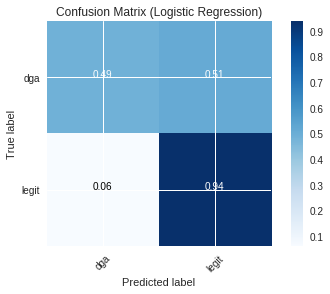

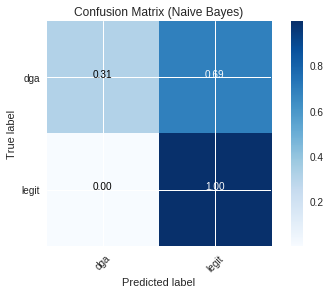

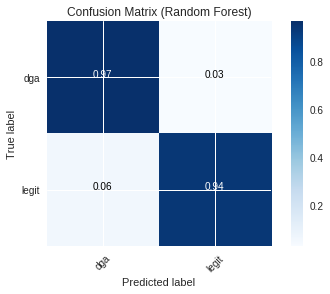

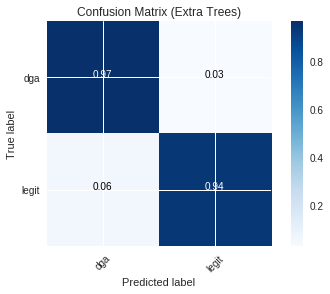

In [30]:
for y_pr, name in zip(y_pred, names):
    cm = confusion_matrix(y_test, y_pr)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1).T[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (" + name + ")")
    plt.colorbar()
    plt.xticks([1, 0], labels, rotation=45)
    plt.yticks([1, 0], labels)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

ROC-кривая 

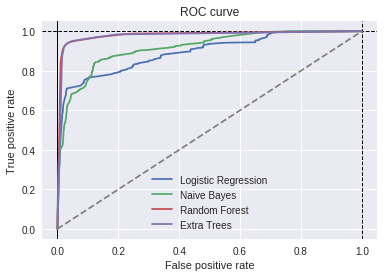

In [31]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = roc_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

Показатель ROC AUC

In [32]:
print("ROC AUC score")
for y_sc, name in zip(y_score, names):
    print(name, " : ", roc_auc_score(y_test, y_sc))

ROC AUC score
Logistic Regression  :  0.8935188644467558
Naive Bayes  :  0.9162474889433031
Random Forest  :  0.9810866550557429
Extra Trees  :  0.9777744889350298


Кривая Точность-Полнота (Precision-Recall)

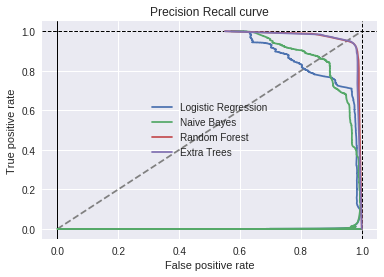

In [33]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
for y_sc, name in zip(y_score, names):
    fpr, tpr, thresholds = precision_recall_curve(y_test, y_sc)
    plt.plot(fpr, tpr, label=name)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.show()

Показатель средней точности (Average Precision)

In [34]:
print("Average Precision score")
for y_sc, name in zip(y_score, names):
    print(name, " : ", average_precision_score(y_test, y_sc))

Average Precision score
Logistic Regression  :  0.9210510031349726
Naive Bayes  :  0.9320497431506268
Random Forest  :  0.9806431016714097
Extra Trees  :  0.9753987636104208
